# Exercise 4

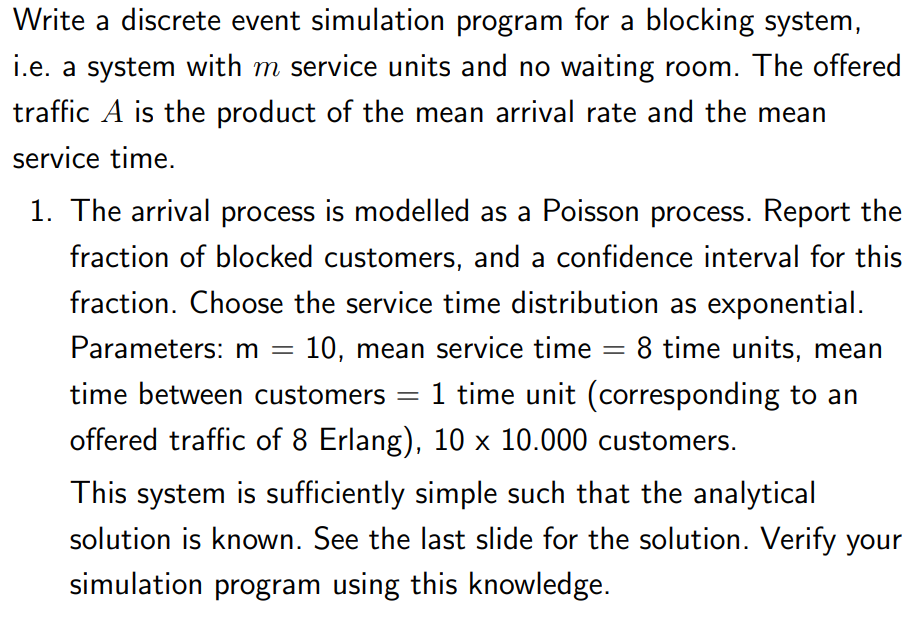

In this assignment, we are supposed to simulate a blocking system with no waiting room, meaning arriving customers either get served or blocked, if no servers are avalaible. We are given:

- $m=10$ servers
- mean service time $=8$
- interarrival time $= 1$
- we should run with 10 batches of 10.000 customers each
- service times are exponential

Using this information, we can begin modelling the problem as a discrete event simulation. I use Poisson-distributed arrivals and exponential arrival times, whereof I can calculate how many customers get blocked when entering the system:

In [13]:
import numpy as np
import heapq
from scipy.stats import norm
import math
np.random.seed(1234)

m = 10  
mean_interarrival = 1
mean_service = 8
num_batches = 10
customers_per_batch = 10000
alpha = 0.05
λ = 1 #arrival rate
µ = 1 / mean_service #service rate

def blocking_system(m, λ, µ, n_customers):
    server_end_times = []
    blocked = 0
    current_time = 0.0

    for _ in range(n_customers):
        interarrival_time = np.random.exponential(1 / λ)
        current_time += interarrival_time
        service_time = np.random.exponential(1 / µ)

        server_end_times = [t for t in server_end_times if t > current_time]

        if len(server_end_times) < m:
            heapq.heappush(server_end_times, current_time + service_time)
        else:
            blocked += 1

    return blocked / n_customers

blocking_fractions = []

for _ in range(num_batches):
    bp = blocking_system(m, λ, µ, customers_per_batch)
    blocking_fractions.append(bp)

mean_blocking = np.mean(blocking_fractions)
std_blocking = np.std(blocking_fractions, ddof=1)
z = norm.ppf(1 - alpha/2)
conf_interval = (mean_blocking - z * std_blocking / np.sqrt(num_batches),
                 mean_blocking + z * std_blocking / np.sqrt(num_batches))

print(f"Estimated blocking probability: {mean_blocking:.4f}")
print(f"95% confidence interval: ({conf_interval[0]:.4f}, {conf_interval[1]:.4f})")


Estimated blocking probability: 0.1211
95% confidence interval: (0.1183, 0.1238)


This means that circa 12% of customers were blocked when arriving, meaning 12% of customers came at a time where all servers $m$ were occupied and thus, these customers were not served. The 95%-confidence also lays nicely around 12%, meaning we are quite certain that 12% of customers would in general be blocked when arriving.

Now, when comparing it to the calculation for the analytical Erlang B result:

In [14]:
def erlang_b(m, A):
    inv_b = 1.0
    for k in range(1, m + 1):
        inv_b = 1 + (k / A) * inv_b
    return 1 / inv_b

A = λ * mean_service  
analytical_blocking = erlang_b(m, A)

print(f"Analytical Erlang B blocking probability: {analytical_blocking:.4f}")
error = abs(mean_blocking - analytical_blocking)
print(f"Absolute error vs simulation: {error:.6f}")

Analytical Erlang B blocking probability: 0.1217
Absolute error vs simulation: 0.000611


Since there is only an absolute error of 0.0006, the simulation can be deemed a sucess, since it produces results consistent with the theoretical Erland B model.

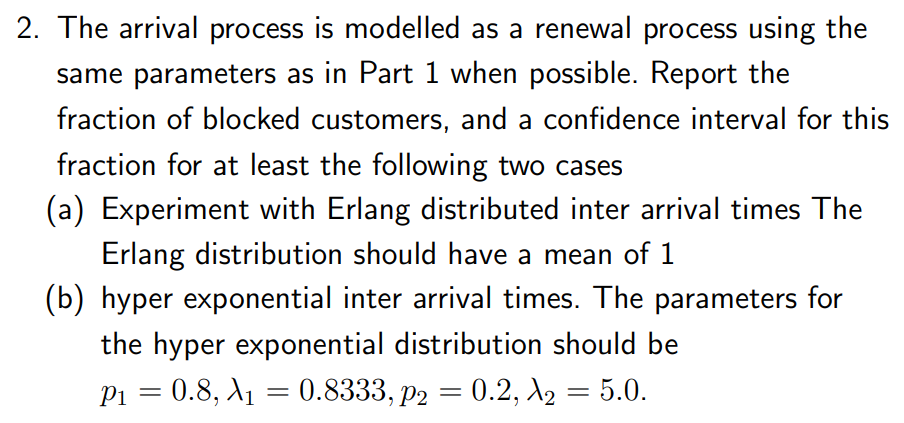

$\textbf{(a)}$ To explore the effect of more regular arrival patterns, we simulate the same blocking system using Erlang-distributed interarrival times, specifically an Erlang(2, 2) distribution. This maintains the same mean of 1 as the original exponential case but with lower variability. The rest of the system parameters remain unchanged.

In [22]:
k = 2
λ = 2

def simulate_with_erlang_arrivals(m, service_rate, n_customers, k, λ):
    server_end_times = []
    blocked = 0
    current_time = 0.0

    for _ in range(n_customers):
        interarrival_time = sum(np.random.exponential(1 / λ, k))
        current_time += interarrival_time
        service_time = np.random.exponential(1 / service_rate)

        server_end_times = [t for t in server_end_times if t > current_time]

        if len(server_end_times) < m:
            heapq.heappush(server_end_times, current_time + service_time)
        else:
            blocked += 1

    return blocked / n_customers


fractions = []
for _ in range(num_batches):
    bp = simulate_with_erlang_arrivals(m, service_rate, customers_per_batch, k, λ)
    fractions.append(bp)

mean_block = np.mean(fractions)
std_block = np.std(fractions, ddof=1)
z = norm.ppf(1 - alpha / 2)
conf = (mean_block - z * std_block / np.sqrt(num_batches),
        mean_block + z * std_block / np.sqrt(num_batches))

print(f"Blocking probability (Erlang arrivals): {mean_block:.4f}")
print(f"95% confidence interval: ({conf[0]:.4f}, {conf[1]:.4f})")

Blocking probability (Erlang arrivals): 0.0940
95% confidence interval: (0.0907, 0.0972)


The simulation shows a blocking probability of approximately 9.06%, with a 95% confidence interval ranging from 8.82% to 9.30%. This is lower than the Poisson arrival case (12%), indicating that reduced arrival variability in the Erlang distribution leads to fewer customers arriving in bursts and thus, reduces the chance of all servers being occupied simultaneously.

$\textbf{(b)}$ Now, we will utilize hyper exponential arrival times in the simulation. We are given the values: $p_1=0.8$, $p_2 = 0.2$, $\lambda_1=0.8333$, and $\lambda_2=5$:

In [21]:
p1 = 0.8
λ1 = 0.8333
p2 = 0.2
λ2 = 5.0

def hyperexp(p1, λ1, p2, λ2):
    if np.random.rand() < p1:
        return np.random.exponential(1 / λ1)
    else:
        return np.random.exponential(1 / λ2)

def simulate_with_hyperexp_arrivals(m, service_rate, n_customers, p1, λ1, p2, λ2):
    server_end_times = []
    blocked = 0
    current_time = 0.0

    for _ in range(n_customers):
        interarrival_time = hyperexp(p1, λ1, p2, λ2)
        current_time += interarrival_time
        service_time = np.random.exponential(1 / service_rate)

        server_end_times = [t for t in server_end_times if t > current_time]

        if len(server_end_times) < m:
            heapq.heappush(server_end_times, current_time + service_time)
        else:
            blocked += 1

    return blocked / n_customers

fractions_hyper = []
for _ in range(num_batches):
    bp = simulate_with_hyperexp_arrivals(m, service_rate, customers_per_batch, p1, λ1, p2, λ2)
    fractions_hyper.append(bp)

mean_block_hyper = np.mean(fractions_hyper)
std_block_hyper = np.std(fractions_hyper, ddof=1)
conf_hyper = (mean_block_hyper - z * std_block_hyper / np.sqrt(num_batches),
              mean_block_hyper + z * std_block_hyper / np.sqrt(num_batches))

print(f"Blocking probability (Hyperexp arrivals): {mean_block_hyper:.4f}")
print(f"95% confidence interval: ({conf_hyper[0]:.4f}, {conf_hyper[1]:.4f})")

Blocking probability (Hyperexp arrivals): 0.1409
95% confidence interval: (0.1379, 0.1439)


This yields a blocking probability of circa 14%, which is noticeably higher than both the exponential and Erland cases, reflecting the increased variability in the arrival process. Specifically, with hyper exponential inter arrival times results in more customers arriving in short time frames, increasing the likelihood of customers not being served (i.e., the blocking probability).

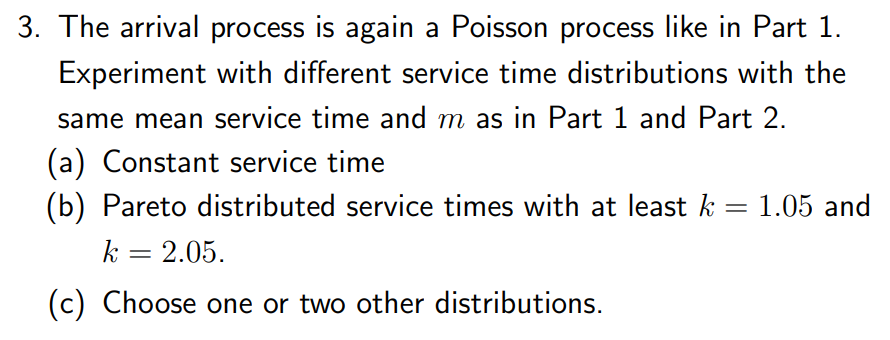

$\textbf{(a)}$ Now, the service time is constant:

In [ ]:
m = 10
mean_interarrival = 1
mean_service = 8
num_batches = 10
customers_per_batch = 10000
alpha = 0.05

def simulate_with_constant_service(m, service_time, n_customers, arrival_rate):
    server_end_times = []
    blocked = 0
    current_time = 0.0

    for _ in range(n_customers):
        interarrival_time = np.random.exponential(1 / arrival_rate)
        current_time += interarrival_time
        s_time = service_time

        server_end_times = [t for t in server_end_times if t > current_time]

        if len(server_end_times) < m:
            heapq.heappush(server_end_times, current_time + s_time)
        else:
            blocked += 1

    return blocked / n_customers

fractions = []
for _ in range(num_batches):
    bp = simulate_with_constant_service(m, mean_service, customers_per_batch, arrival_rate=1)
    fractions.append(bp)

mean_block = np.mean(fractions)
std_block = np.std(fractions, ddof=1)
z = norm.ppf(1 - alpha / 2)
conf = (mean_block - z * std_block / np.sqrt(num_batches),
        mean_block + z * std_block / np.sqrt(num_batches))

print(f"Blocking probability: {mean_block:.4f}")
print(f"95% confidence interval: ({conf[0]:.4f}, {conf[1]:.4f})")

Blocking probability: 0.1251
95% confidence interval: (0.1224, 0.1279)


This is quite similar to the exponential case, it makes sense since the mean service time is the same. While this case reduces service variability, it does not affect the inherent randomness of the arrivals.

$\textbf{(b)}$ Now, we set the service time to be both Pareto distributed with atleast $k=1.05$ and maximumally $k_1=2.05$

This yields a blocking probability of circa 14%, which is noticeably higher than both the exponential and Erland cases, reflecting the increased variability in the arrival process. Specifically, with hyper exponential inter arrival times results in more customers arriving in short time frames, increasing the likelihood of customers not being served (i.e., the blocking probability).

In [ ]:
def pareto_service_time(k, mean_target):
    beta = mean_target * (k - 1) / k
    return (np.random.pareto(k) + 1) * beta  

def simulate_with_pareto_service(m, arrival_rate, n_customers, k, mean_target):
    server_end_times = []
    blocked = 0
    current_time = 0.0

    for _ in range(n_customers):
        interarrival_time = np.random.exponential(1 / arrival_rate)
        current_time += interarrival_time
        s_time = pareto_service_time(k, mean_target)

        server_end_times = [t for t in server_end_times if t > current_time]

        if len(server_end_times) < m:
            heapq.heappush(server_end_times, current_time + s_time)
        else:
            blocked += 1

    return blocked / n_customers

for k in [1.05, 2.05]:
    fractions = []
    for _ in range(num_batches):
        bp = simulate_with_pareto_service(m, arrival_rate=1, n_customers=customers_per_batch, k=k, mean_target=8)
        fractions.append(bp)

    mean_block = np.mean(fractions)
    std_block = np.std(fractions, ddof=1)
    z = norm.ppf(1 - alpha / 2)
    conf = (mean_block - z * std_block / np.sqrt(num_batches),
            mean_block + z * std_block / np.sqrt(num_batches))

    print(f"\nPareto service times (k = {k}):")
    print(f"Blocking probability: {mean_block:.4f}")
    print(f"95% confidence interval: ({conf[0]:.4f}, {conf[1]:.4f})")



Pareto service times (k = 1.05):
Blocking probability: 0.0008
95% confidence interval: (0.0001, 0.0015)

Pareto service times (k = 2.05):
Blocking probability: 0.1208
95% confidence interval: (0.1164, 0.1252)


With $k=1.05$, the blocking probability is miniscule - almost 0. This is due to fewer arrivals happening during busy periods and thus, less blocking.

On the other hand, as for $k=2.05$, the blocking probability is at circa 12%, which is more in line with previous results.